In [9]:
# import libraries
%matplotlib inline
import re
import os 
import pickle
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean 
from time import time
import plotly.graph_objects as go

import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from textblob import TextBlob, Word
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YZD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YZD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YZD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
os.chdir(r'C:\Users\YZD\Desktop\NUS\MSBA\Semster 2 - 2020\BT5153 - Applied Machine Learning for Business Analytics\Project\data\scrap_data')
all_filenames = os.listdir()
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [16]:
df_tweet = pd.read_csv('combined_csv.csv')

In [17]:
print(df_tweet.shape)

(100000, 4)


## EDA on combined dataset  

In [18]:
print('Train dataset : \n', df_tweet.shape, '\n', df_tweet.head(5), '\n', df_tweet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
id          100000 non-null int64
date        100000 non-null object
username    100000 non-null object
text        99972 non-null object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB
Train dataset : 
 (100000, 4) 
                     id                       date         username  \
0  1245501195478691840  2020-04-01 23:59:59+00:00         DotUrada   
1  1245501195004907521  2020-04-01 23:59:59+00:00  YouthBeatSpeaks   
2  1245501194950389761  2020-04-01 23:59:59+00:00    41_POR_CIENTO   
3  1245501194379898880  2020-04-01 23:59:59+00:00         SangerJB   
4  1245501193352146944  2020-04-01 23:59:59+00:00   KrissyKrissy16   

                                                text  
0  Nurses: We Are the Canaries in the Coronavirus...  
1  On 3/26, @emergesmarter hosted their 1st live ...  
2  Coronavirus en Argentina: ¿Es buena noticia qu...  
3  Pompeo refuses 6 times to s

In [19]:
print('Number of missing text:')
print(df_tweet.isnull().sum())

Number of missing text:
id           0
date         0
username     0
text        28
dtype: int64


In [20]:
# drop na row 
df_tweet = df_tweet.dropna()

In [21]:
print(df_tweet['text'][0])

Nurses: We Are the Canaries in the Coronavirus Mine - https://go.shr.lc/2UCpqaF via @commondreams


In [22]:
print(df_tweet.isnull().sum())

id          0
date        0
username    0
text        0
dtype: int64


## Text Cleaning 

We will be using the NLTK package to apply the same text cleaning process for both kaggle dataset and scraped tweets dataset. The ultimate aim is to standardize and remove any discrepancy. The process includes : 

1. Split by whitespace 
2. Remove non english characters & Punctuation
3. Lowercase transformation 
4. Split by whitespace 
5. Filter out Stop words
6. Stem Words 
7. Tokenization


In [23]:
# Data Cleaning 
def cleaning(text): 

    # Convert to smaller case
    text_lower = text.lower()
    # print('\n lower :\n', text_lower, '\n')
    # print(type(text_lower))
    
    # Handle all the short form
    text_noshort = re.sub(r"what's", "what is ", text_lower)
    text_noshort = re.sub(r"\'s", " ", text_noshort)
    text_noshort = re.sub(r"\'ve", " have ", text_noshort)
    text_noshort = re.sub(r"can't", "can not ", text_noshort)
    text_noshort = re.sub(r"n't", " not ", text_noshort)
    text_noshort = re.sub(r"i'm", "i am ", text_noshort)
    text_noshort = re.sub(r"\'re", " are ", text_noshort)
    text_noshort = re.sub(r"\'d", " would ", text_noshort)
    text_noshort = re.sub(r"\'ll", " will ", text_noshort)
    text_noshort = re.sub(r"\'scuse", " excuse ", text_noshort)
    text_noshort = re.sub(r'http\S+', '', text_noshort)
    # print('No short : ', text_noshort, '\n')
    # print(type(text_noshort))

    # Remove special character & whitespaces
    text_nochar = re.sub(r"\W+|_",' ', text_noshort)
    # print('special character :\n', text_nochar, '\n')
    # print(type(text_nochar))

    # Remove numbers 
    # text_nonumber = re.sub(r'\d+', '', text_nochar)
    # print(text_nonumber)
    # print(type(text_nonumber))
    
    # Eliminate duplicate whitespaces using wildcards
    text_dup_space = re.sub('\s+', ' ', text_nochar)
    # print('duplicate whitespace : ', text_dup_space, '\n')
    # print(type(text_dup_space))

    # Remove leading and trailing space
    text_trim_space = text_dup_space.strip(' ')
    # print('leading &  trailing space : ', text_trim_space, '\n')
    # print(type(text_trim_space))

    # Filter out stop words
    stop_words = set(stopwords.words('english'))
    word_tokens=word_tokenize(text_trim_space)
    filtered_text=" ".join([w for w in word_tokens if not w in stop_words])
    # filtered_text = [w for w in text_noempty if not w in stop_words] 
    # print('filter stop words :\n',filtered_text, '\n')
    # # print(type(filtered_text))

    # # Lemmatizing - words in third person are changed to first person and verbs in past and future tenses are changed into present.
    # lemmatizer = WordNetLemmatizer() 
    # # output List
    # lemmated = []
    # for word in filtered_text :
    #     lemmated.append(lemmatizer.lemmatize(word))
   
    # # Output string
    ft_split = filtered_text.split(" ")
    lemmated=" ".join([Word(w).lemmatize() for w in ft_split])
    # print('lemmatizing :\n', lemmated, '\n')
    # print(type(lemmated))

    # Stemmed — words are reduced to their root form
    stemmer = SnowballStemmer("english")
    word_split = lemmated.split(" ")
    stemmed = " ".join([stemmer.stem(w) for w in word_split])
    # print('stemmed : ', stemmed, '\n')
    
    return stemmed

In [24]:
# data processing

df_tweet['text'] = df_tweet['text'].apply(lambda x : cleaning(x))

In [25]:
# Remove rows where text are empty
df_tweet = df_tweet[df_tweet['text'] != '']

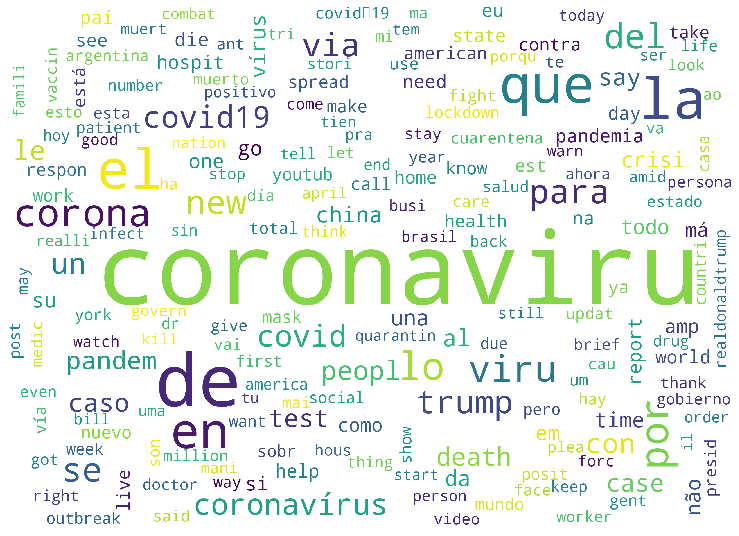

In [26]:
plt.figure(1,figsize=(13, 13))
# clean
text = df_tweet.text.values
cloud_word = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.imshow(cloud_word)

## Topic Modeling and Latent Dirichlet Allocation (LDA)
- Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents.
- LDA is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model,    modeled as Dirichlet distributions.

In [136]:
print(df_tweet.columns)
print(df_tweet.shape)

Index(['id', 'date', 'username', 'text'], dtype='object')
(99951, 4)


In [27]:
#word
def get_top_n_words(corpus):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    print('bag shape: ', bag_of_words.shape)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

common_words = get_top_n_words(df_tweet['text'])
df5 = pd.DataFrame(common_words, columns = ['word' , 'count'])
print(df5)


bag shape:  (99951, 106192)
                word  count
0        coronavirus  88314
1                 de  38870
2                 la  21848
3                 el  20660
4                que  19488
...              ...    ...
106187       yourdad      1
106188     seríssimo      1
106189        ceifou      1
106190        ceifar      1
106191  lulinhaslivr      1

[106192 rows x 2 columns]


In [138]:
print(df5.describe())

count
count  106192.000000
mean       14.750066
std       341.297090
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max     88314.000000


In [139]:
#unigram
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_tweet['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 unigrams in the tweet text"))
fig.update_xaxes(tickangle=45)
fig.show()

In [140]:
#bigram
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_tweet['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the comment text"))
fig.update_xaxes(tickangle=45)
fig.show()

In [141]:
#trigram
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_tweet['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the comment text"))
fig.update_xaxes(tickangle=45)
fig.show()

In [28]:
#input=df_train['comment_text']
#ngram_range=(1,3), max_features=5000
#optimal=3

#tf for LDA model
cv = CountVectorizer(max_df=0.75, ngram_range=(1,3), max_features=10000) #max_features=10000, 
word_count_vector = cv.fit_transform(df_tweet['text'])

#finding optimal number of topics for LDA model 
print("Fitting LDA models with %d samples and %d TF features ..."
      % (word_count_vector.shape[0], word_count_vector.shape[1]))
t0 = time()
ids = []
ppls = []
logs = []
for n in range(2,16):
    lda = LDA(n_components=n,               
          max_iter=3,
          learning_offset=10.,    
          learning_method='online', 
          random_state=100,
          batch_size=128,
          n_jobs=-1,
          verbose=1)
    lda.fit(word_count_vector)
    ppl_score = lda.bound_
    ll_score = lda.score(word_count_vector)
    ids.append(n)
    ppls.append(ppl_score)
    logs.append(ll_score)
    
print("Done in %0.3fs." % (time() - t0))

Fitting LDA models with 99951 samples and 10000 TF features ...
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1 of max_iter: 3
iteration: 2 of max_iter: 3
iteration: 3 of max_iter: 3
iteration: 1

Text(0, 0.5, 'perplexity')

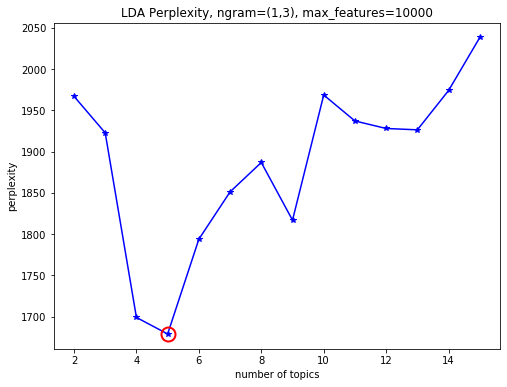

In [33]:
# Plot
kIdx1 = np.argmin(ppls)

fig = plt.figure(figsize=(8, 6))
plt.plot(ids, ppls, 'b*-')
plt.plot(ids[kIdx1], ppls[kIdx1], marker='o', markersize=14, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.title('LDA Perplexity, ngram=(1,3), max_features=10000')
plt.xlabel('number of topics')
plt.ylabel('perplexity')

Text(0, 0.5, 'LogLikelyhood')

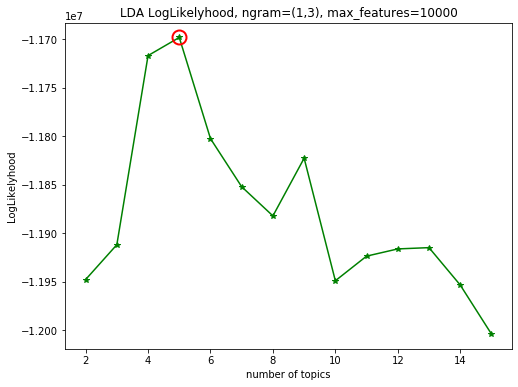

In [34]:
kIdx2 = np.argmax(logs)

fig = plt.figure(figsize=(8, 6))
plt.plot(ids, logs, 'g*-')
plt.plot(ids[kIdx2], logs[kIdx2], marker='o', markersize=14, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.title('LDA LogLikelyhood, ngram=(1,3), max_features=10000')
plt.xlabel('number of topics')
plt.ylabel('LogLikelyhood')
# fig.savefig('lda_LogLikelyhood_max_features=5000_stem_clean.png')

In [38]:
# print top words per topic
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))  

In [39]:
# Build LDA Model with optimal number of topics = 15
# input = text_data.stem_clean
# input shape = (180091, 5000)

#tf for LDA model
cv = CountVectorizer(max_df=0.75, ngram_range=(1,3), max_features=5000) #max_features=10000, 
word_count_vector = cv.fit_transform(df_tweet['text'])

print("Fitting LDA models with %d samples and %d TF features ..."
      % (word_count_vector.shape[0], word_count_vector.shape[1]))
t0 = time()

lda_model = LDA(n_components=5,         # Number of topics
              max_iter=10,                # Max learning iterations
              learning_offset=10., 
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every=-1,       # compute perplexity every n iters, default: Don't
              n_jobs=-1,               # Use all available CPUs
              verbose=1)
    
lda_output = lda_model.fit_transform(word_count_vector)
print("Done in %0.3fs." % (time() - t0))

print(lda_model)  # Model attributes

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(word_count_vector))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(word_count_vector))

# Print the topics found by the LDA model
print("Topics found via LDA Model:")
print_topics(model=lda_model, vectorizer=cv, n_top_words=15)

Fitting LDA models with 99951 samples and 5000 TF features ...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Done in 322.880s.
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=1)
Log Likelihood:  -9574744.288653513
Perplexity:  1050.1210171235564
Topics found via LDA Model:

Topic #0:
de, la, el, en, que, por, los, del,

In [40]:
# Print the topics found by the LDA model
print("Topics found via LDA Model:")
print_topics(model=lda_model, vectorizer=cv, n_top_words=15)

Topics found via LDA Model:

Topic #0:
de, la, el, en, que, por, los, del, el coronavirus, se, un, con, para, de coronavirus, de la

Topic #1:
de, covid, coronavírus, 19, que, covid 19, corona, da, vírus, corona vírus, não, em, com, eu, para

Topic #2:
trump, via, peopl, new, pandem, say, get, test, covid19, time, like, go, news, coronavirus pandem, china

Topic #3:
virus, corona, corona virus, death, case, le, covid19, 000, covidー19, stay, coronavirus case, coronavirus death, via, vaccin, covid19 coronavirus

Topic #4:
si, contra, no, crisi, te, contra el, bbc, contra el coronavirus, news, el, la crisi, por, bbc news, la, tiger


In [43]:
def get_lda_topics(model, vectorizer, num_topics, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {}
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic #' + '{:d}'.format(i)] = words
    
    return pd.DataFrame(word_dict)

get_lda_topics(model=lda_model, vectorizer=cv, num_topics=5, n_top_words=15)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4
0,de,de,trump,virus,si
1,la,covid,via,corona,contra
2,el,coronavírus,peopl,corona virus,no
3,en,19,new,death,crisi
4,que,que,pandem,case,te
5,por,covid 19,say,le,contra el
6,los,corona,get,covid19,bbc
7,del,da,test,000,contra el coronavirus
8,el coronavirus,vírus,covid19,covidー19,news
9,se,corona vírus,time,stay,el
